### Tasca Final

Les dades utilitzades per a aquesta tasca final són del consum d’electricitat diari per codi postal, sector econòmic i tram horari a la ciutat de Barcelona, segons les dades proporcionades per la plataforma Datadis i disponibles a https://opendata-ajuntament.barcelona.cat/data/ca/dataset/consum-electricitat-bcn/resource/25caee3a-a9f2-4e1a-8c8b-1b5fcac4f152.

Les dades van des del Gener de 2019 fins al Març de 2023. Conté originalment 6 variables:

- Any
- Data
- Codi_Postal
- Sector_Econòmic -> Indústria, Serveis, Residencial i No Especificat.
- Tram_Horari -> de 0 a 5h59m, de 6h a 11h59m, de 12h a 17h59m, de 18h a 23h59m i No Consta.
- Valor -> en unitats MWh

### Anàlisis del dataset

In [1]:
#Importem les llibreries necessàries

%matplotlib nbagg
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import pandas_bokeh
import pgeocode
import geopandas as gpd
from shapely.geometry import Point
from geopandas import GeoDataFrame
pandas_bokeh.output_notebook()
import plotly.graph_objects as go
import plotly.express as px


Loading BokehJS ...

Llegim els arxius anuals individualment i seguidament els ajuntem en un sol *dataframe* (df). 
Degut a que el codi postal és llegit sense el 0 inicial. S'ha corretjit incloent aquest 0 manualment.

In [2]:
df19 = pd.read_csv('2019_consum_electricitat_bcn.csv', sep=',')
df20 = pd.read_csv('2020_consum_electricitat_bcn.csv', sep=',')
df21 = pd.read_csv('2021_consum_electricitat_bcn.csv', sep=',')
df22 = pd.read_csv('2022_consum_electricitat_bcn.csv', sep=',')
df23 = pd.read_csv('2023_consum_electricitat_bcn.csv', sep=',')

df = pd.concat([df19, df20, df21, df22, df23], axis=0)
df['Codi_Postal'] = '0' + df['Codi_Postal'].astype('string')

Donem un cop d'ull als tipus de cada variable

In [3]:
df.dtypes

Any                         int64
Data                       object
Codi_Postal        string[python]
Sector_Economic            object
Tram_Horari                object
Valor                       int64
dtype: object

Transformem la columna Data a format *datetime* i incluim els dies, mesos, i any en columnes independents. Aquestes dades poden ser interessants en cas de fer un anàlisis específic per dia, mes, etc.

També renomanem els elements de la variable *Sector*:
 - Indústria = 1
 - Residencial = 2
 - Serveis = 3
 - No especificat = 0
 
Farem servir la mateixa estratègia pels trams horaris *Tram*:
 - De 00:00:00 a 05:59:59 h = 1
 - De 06:00:00 a 11:59:59 h = 2
 - De 12:00:00 a 17:59:59 h = 3
 - De 18:00:00 a 23:59:59 h = 4
 - No consta                = 0

In [4]:
df['Data'] = pd.to_datetime(df['Data'])
df['Dia'] = df.Data.dt.day
df['Mes'] = df.Data.dt.month
df['Any'] = df.Data.dt.year

for el in df:
    df.loc[df['Tram_Horari'] == 'De 00:00:00 a 05:59:59 h', 'Tram'] = 1
    df.loc[df['Tram_Horari'] == 'De 06:00:00 a 11:59:59 h', 'Tram'] = 2
    df.loc[df['Tram_Horari'] == 'De 12:00:00 a 17:59:59 h', 'Tram'] = 3
    df.loc[df['Tram_Horari'] == 'De 18:00:00 a 23:59:59 h', 'Tram'] = 4
    df.loc[df['Tram_Horari'] == 'No consta', 'Tram'] = 0
    
df['Tram'] = df['Tram'].astype(int)


for el in df:
    df.loc[df['Sector_Economic'] == 'Indústria', 'Sector'] = 1
    df.loc[df['Sector_Economic'] == 'Residencial', 'Sector'] = 2
    df.loc[df['Sector_Economic'] == 'Serveis', 'Sector'] = 3
    df.loc[df['Sector_Economic'] == 'No especificat', 'Sector'] = 0
    
df['Sector'] = df['Sector'].astype(int)

df.head(6)

Any       Data Codi_Postal Sector_Economic               Tram_Horari  \
0  2019 2019-01-01       08001       Indústria  De 00:00:00 a 05:59:59 h   
1  2019 2019-01-01       08001       Indústria  De 06:00:00 a 11:59:59 h   
2  2019 2019-01-01       08001       Indústria  De 12:00:00 a 17:59:59 h   
3  2019 2019-01-01       08001       Indústria  De 18:00:00 a 23:59:59 h   
4  2019 2019-01-01       08001       Indústria                 No consta   
5  2019 2019-01-01       08001     Residencial  De 00:00:00 a 05:59:59 h   

   Valor  Dia  Mes  Tram  Sector  
0    727    1    1     1       1  
1    855    1    1     2       1  
2   1175    1    1     3       1  
3   1214    1    1     4       1  
4    106    1    1     0       1  
5  28259    1    1     1       2

Finalment ens quedem amb les columne d'interès.

In [5]:
df = df[['Dia', 'Mes', 'Any', 'Data','Codi_Postal', 'Sector', 'Tram', 'Valor']]

També iclourem al nostre *dataframe* les latituts i longituts del codi postal. Això ens ajudarà a situar aquests codis postal de forma visual en un mapa. Mostrem les primeres cinc dades extretes a partir del codi postal mitjançant el paquet *pgeocode*.

In [6]:
nomi = pgeocode.Nominatim('es')

df['Latitude'] = (nomi.query_postal_code(df['Codi_Postal'].tolist()).latitude)
df['Longitude'] = (nomi.query_postal_code(df['Codi_Postal'].tolist()).longitude)

nomi.query_postal_code(df['Codi_Postal'].unique()).head()

postal_code country_code place_name state_name state_code county_name  \
0       08001           ES  Barcelona   Cataluna         CT   Barcelona   
1       08002           ES  Barcelona   Cataluna         CT   Barcelona   
2       08003           ES  Barcelona   Cataluna         CT   Barcelona   
3       08004           ES  Barcelona   Cataluna         CT   Barcelona   
4       08005           ES  Barcelona   Cataluna         CT   Barcelona   

  county_code community_name  community_code  latitude  longitude  accuracy  
0           B      Barcelona          8019.0   41.3799     2.1687         4  
1           B      Barcelona          8019.0   41.3823     2.1760         4  
2           B      Barcelona          8019.0   41.3831     2.1848         4  
3           B      Barcelona          8019.0   41.3722     2.1593         4  
4           B      Barcelona          8019.0   41.3984     2.2005         4

I visualitzem les 7 primeres instàncies del *dataframe* final

In [7]:
df.head(7)

Dia  Mes   Any       Data Codi_Postal  Sector  Tram  Valor  Latitude  \
0    1    1  2019 2019-01-01       08001       1     1    727   41.3799   
1    1    1  2019 2019-01-01       08001       1     2    855   41.3799   
2    1    1  2019 2019-01-01       08001       1     3   1175   41.3799   
3    1    1  2019 2019-01-01       08001       1     4   1214   41.3799   
4    1    1  2019 2019-01-01       08001       1     0    106   41.3799   
5    1    1  2019 2019-01-01       08001       2     1  28259   41.3799   
6    1    1  2019 2019-01-01       08001       2     2  28583   41.3799   

   Longitude  
0     2.1687  
1     2.1687  
2     2.1687  
3     2.1687  
4     2.1687  
5     2.1687  
6     2.1687

A partir de les latitus i longituts, situem els codis postals en un mapa. Passant el cursor pels punts blaus veurem el codi postal, la latitut i la la longitut de cada punt.

In [17]:
fig = px.scatter_mapbox(
    df['Codi_Postal'].unique(),
    lat=df['Latitude'].unique(),
    lon=df['Longitude'].unique(),
    hover_name=df['Codi_Postal'].unique(),
    zoom=11,
    height=500,
    #size=df.groupby(['Codi_Postal'])['Valor'].mean()

)
fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r": 0, "t": 0, "l": 0, "b": 0})
fig.update_traces(marker=dict(size=18))
fig.show()

fig.write_html('Mapa_Codis_Postals.html')

Un cop situats en el mapa, analitzarem la variable *Valor* que és la dada quantitativa més interessant i la que ens dóna la informació de consum.

In [9]:
df[df['Sector']!=0].groupby('Sector')['Valor'].describe()

count          mean           std  min      25%      50%       75%  \
Sector                                                                          
1       325710.0   7850.982856  19314.980486  0.0    489.0   1587.0   3904.00   
2       325710.0  29285.927147  22386.908135  0.0  11900.0  28637.0  43482.00   
3       325710.0  45249.949569  40428.886383  0.0  13764.0  38229.0  67238.75   

             max  
Sector            
1       434408.0  
2       260278.0  
3       333610.0

Observant el valors mitjants, notem que Serveis (3) és el sector que més consumeix seguit del sector Residencial (2) i l'Industrial (1). Tots tres amb desviacions standart grans, probablament relacionats als trams. 

A seguir, mostrem les distribucions de valor en funció de la probabilitat. Observem pics molt alts i estrets en valors baixos en els tres casos. En el sector industruial, la distribució decau de forma exponencial però en els sectors Residencial i Serveis mostren dos *bumps*, el de Serveis una cua més llarga que el de Residencial.

<IPython.core.display.Javascript object>


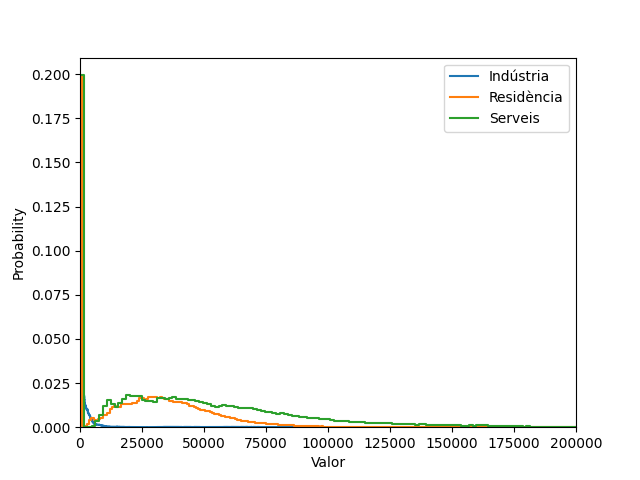

In [18]:
fig, ax = plt.subplots()

sns.histplot(df[df['Sector']==1]['Valor'], element='step', fill=False, stat='probability', label='Indústria')
sns.histplot(df[df['Sector']==2]['Valor'], element='step', fill=False, stat='probability', label='Residència')
sns.histplot(df[df['Sector']==3]['Valor'], element='step', fill=False, stat='probability', label='Serveis')

ax.set_xlim(0,200000)
plt.legend()

plt.savefig('Distribució_Valor_per_Sector.png')

Per intentar entendre aquests pics, analitzarem individualment les distribucions, ara, però, les distribucions es mostren per trams.

<IPython.core.display.Javascript object>


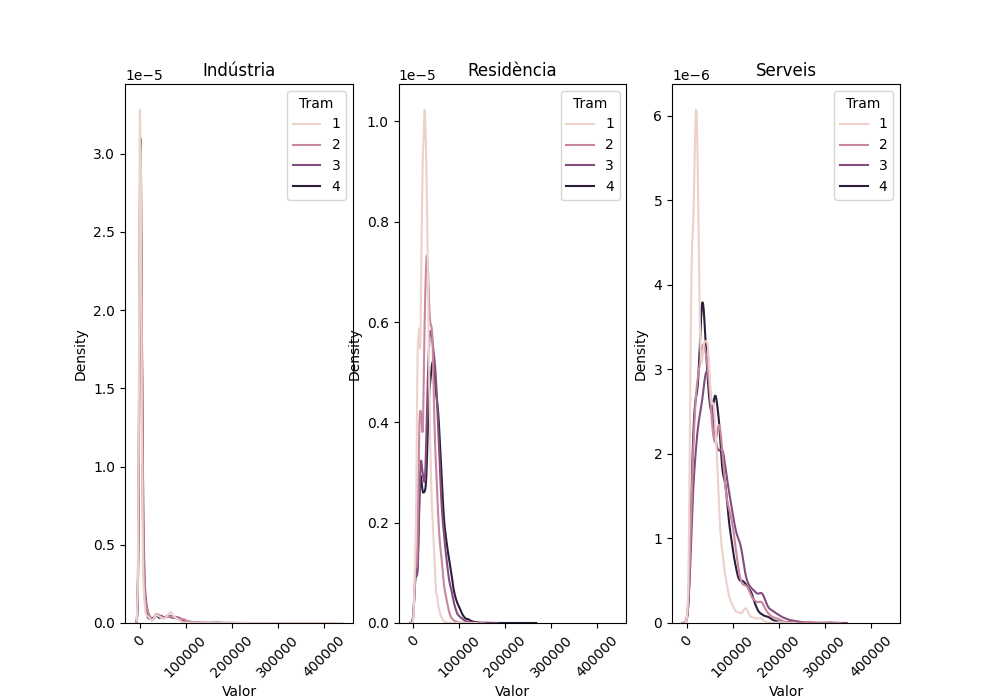

/tmp/ipykernel_348310/3081876015.py:7: UserWarning:

FixedFormatter should only be used together with FixedLocator

/tmp/ipykernel_348310/3081876015.py:8: UserWarning:

FixedFormatter should only be used together with FixedLocator

/tmp/ipykernel_348310/3081876015.py:9: UserWarning:

FixedFormatter should only be used together with FixedLocator



In [19]:
fig, ax = plt.subplots(1,3,figsize=(10,7), sharex=True)

g1 = sns.kdeplot(data=df[(df['Sector']==1) & (df['Tram']!=0)], x='Valor',hue='Tram',ax=ax[0])
g2 = sns.kdeplot(data=df[(df['Sector']==2) & (df['Tram']!=0)], x='Valor',hue='Tram',ax=ax[1])
g3 = sns.kdeplot(data=df[(df['Sector']==3) & (df['Tram']!=0)], x='Valor',hue='Tram',ax=ax[2])

g1.set_xticklabels(g1.get_xticklabels(), rotation=45)
g2.set_xticklabels(g2.get_xticklabels(), rotation=45)
g3.set_xticklabels(g3.get_xticklabels(), rotation=45)

ax[0].set_title('Indústria')
ax[1].set_title('Residència')
ax[2].set_title('Serveis')

plt.savefig('Distribució_Valor_per_Sector_individual.png')

En el sector Indústria no hi ha diferències significatives en els diferents Trams. Ja en el Residencial i Serveis observem que els *bumps* són deguts als diferents trams horaris. 

El mateix es pot veure més fàcilment amb un gràfic de barres, en el qual com comentat, veiem poques diferències en els diferents Trams pel sector Indústria (1). En el sector Residència (2) hi ha un clar augment de consum a mesura que passa el dia. Ja en el sector Serveis, el consum més elevat està entre les 6 del matí i les 6 de la tarda, que té tot el sentit pels horaris dels serveis a la ciutat.

<IPython.core.display.Javascript object>


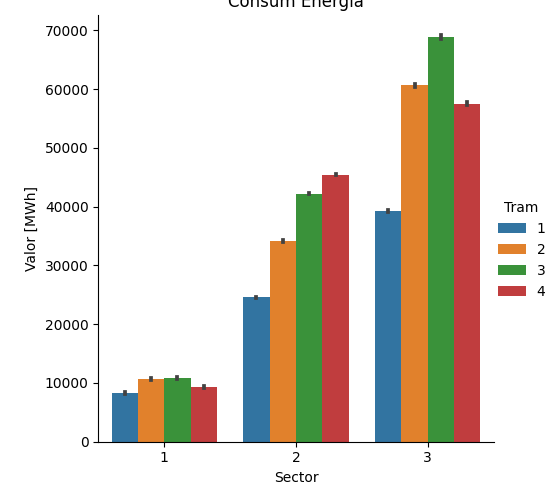

In [20]:
sns.catplot(x="Sector", y="Valor", hue="Tram", kind="bar", data=df[(df['Sector']!=0) & (df['Tram']!=0)])
plt.title('Consum Energia')
plt.ylabel('Valor [MWh]')
plt.show()

plt.savefig('Consum_Energia_Sector_Tram.png')

Finalment mostrem la descripció del Valor per Trams. Els consums més elevats de mitja són als trams horaris de 12h a 18h, de 18h a 0h, de 6h a 12h i de 0h a 6h respectivament.


In [14]:
df[df['Tram']!=0].groupby('Tram')['Valor'].describe()

count          mean           std  min     25%      50%       75%  \
Tram                                                                         
1     209346.0  22474.231215  23416.955185  1.0  1883.0  18569.0  32904.75   
2     209346.0  32822.601631  33820.738908  0.0  3358.0  26915.5  47706.00   
3     209346.0  37963.343202  38137.644615  2.0  3825.0  32600.5  56366.00   
4     209346.0  34970.383298  33553.711377  1.0  2924.0  31372.0  55474.75   

           max  
Tram            
1     434408.0  
2     323244.0  
3     333610.0  
4     287292.0

Pot cridar l'atenció que el sector Indústria sigui el que menys consumeix, no obstant, és necessàri, per un anàlisis més acurat entendre la realitat de la ciutat, en aquest cas Barcelona, on les indústria pot estar concentrada a punts de l'àrea metroplolitana on no tenim la informació en aquest *dataframe*.

Podriem intentar veure si hi ha concentracions d'algún dels sectors per Codi Postal.

<IPython.core.display.Javascript object>


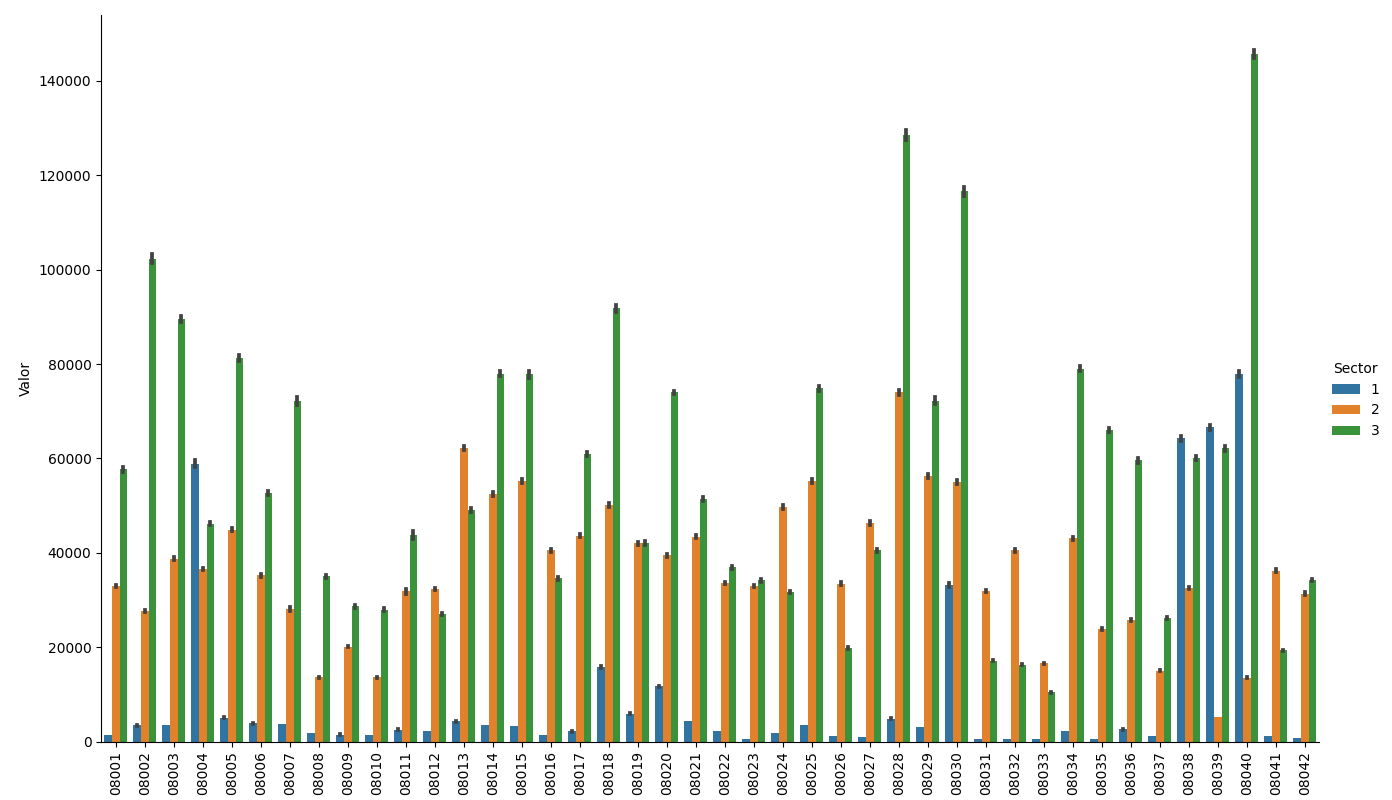

In [23]:
sns.catplot(x="Codi_Postal", y="Valor", hue="Sector", kind="bar", data=df[(df['Sector']!=0) & (df['Tram']!=0)],
           height=8, aspect=5/3)
plt.xticks(rotation=90)

plt.savefig('Valor_vs_CP_hue_Sector.png')

En general, veiem com el sector serveis predomina per sobre del Residencial, en alguns casos de forma ajustada (08023) en altres de forma clara (08028). Aquesta predominància és clara també en el consum. El que crida l'atenció, és que hi ha una alta concentració del sector Indústria en cinc codis postals: 08004, 08038, 08039, 08040 i 08030. Els quatre primer tots en una mateixa regió prop del port on podem entendre que hi ha la major concentració, i la major part del consum en el sector industrial.

Fent el mateix exercici però ara per Trams horaris, confirmem la tendència de més KWh gastats en el tercer tram horari, seguit del quart, segon i el primer ja amb ben menys consum. Quant hi ha un domini d'un sector sobre els altres (ex. 08033) on la Residència és dominant, la tendència del consum en cada tram horari és crreixent. El codi 08040 dominat per la indústria mostra un perfil més equilibrat entre els trams i en un codi (08018) dominant pels serveis veiem també el pic en el tercer tram horari (12h a 18h) i més ajustat entre el segon i el quart com havíem indicat en el primer gràfic de barres. Tenint en compte aquestes tendències podriem intentar saber quin és el sector dominant mitjançant els trams, però aquest no és l'objectiu d'aquest treball.

<IPython.core.display.Javascript object>


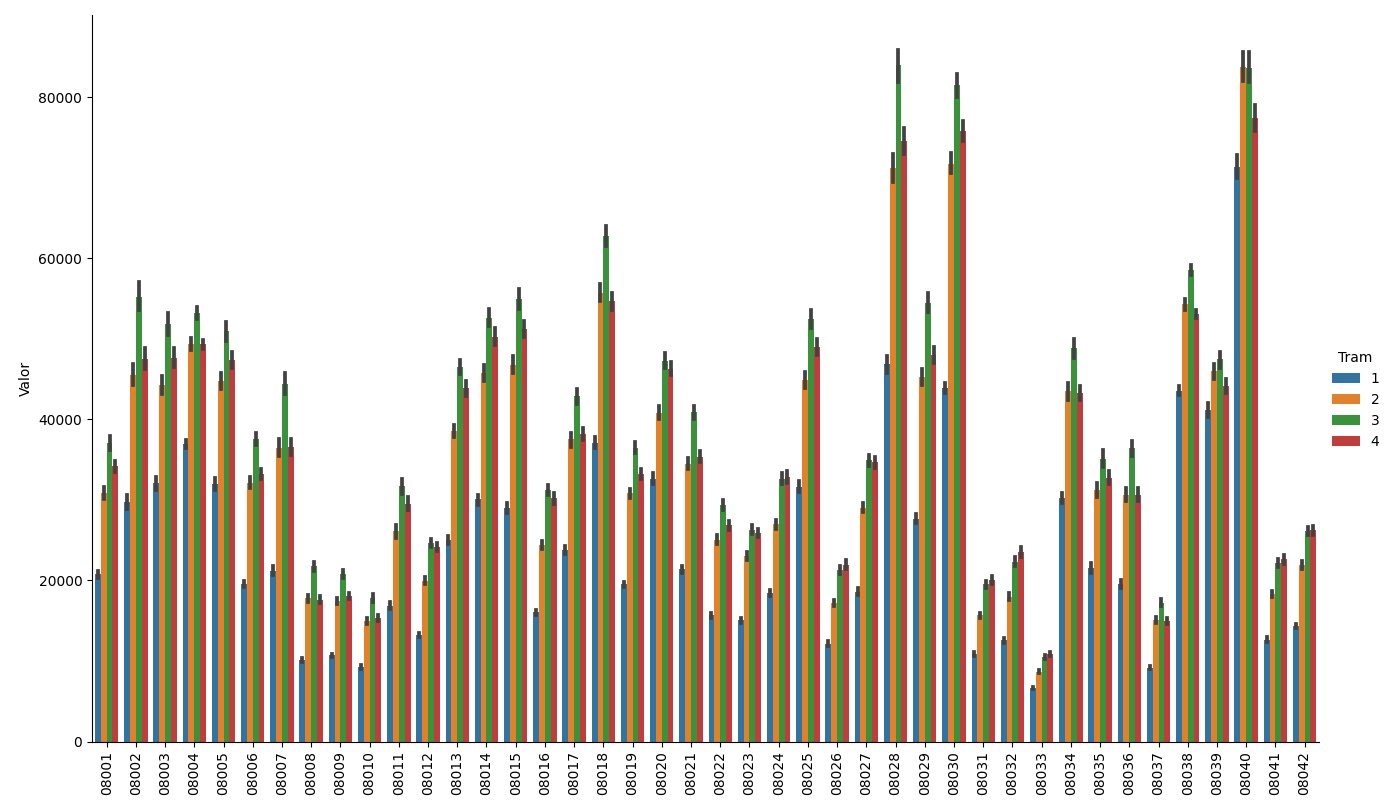

In [22]:
sns.catplot(x="Codi_Postal", y="Valor", hue="Tram", kind="bar", data=df[(df['Sector']!=0) & (df['Tram']!=0)],
           height=8, aspect=5/3)
plt.xticks(rotation=90)

plt.savefig('Valor_vs_CP_hue_Tram.png')

#### Serie Temporal

A seguir analitzarem com varia la sèrie temporal en els quate anys i tres mesos que tenim de dades. En un primer moment mostrem el consum (MWh) en el temps. Observem una série d'oscilacions algune amb una amplitud més significtiva que d'altres. Podria tractar-se de diferents cicles. Els més llargs degut a comportaments de consum en diferents mesos i estacions. Els més curts, referents a variacions de consum per sector i tram. Però és difícil identificar-los a simple vista.

<IPython.core.display.Javascript object>


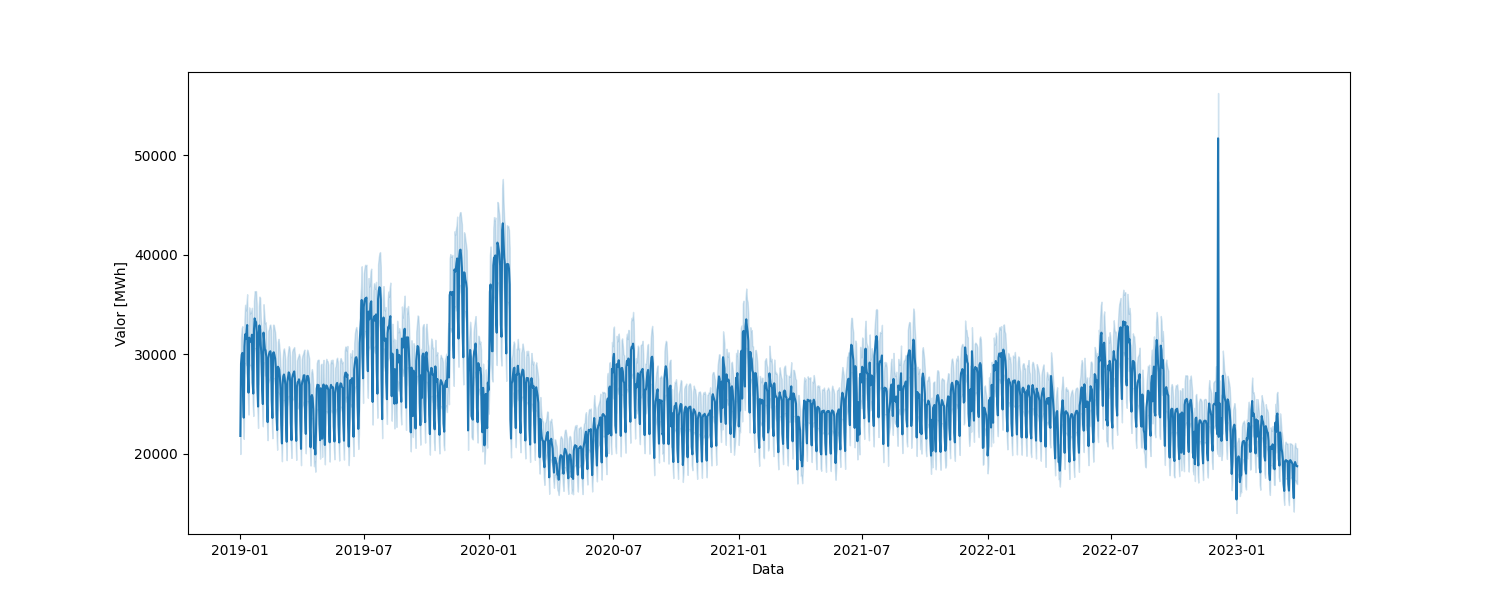

In [24]:
fig, ax = plt.subplots(figsize=(15,6))
sns.lineplot(x='Data', y='Valor', data=df)

ax.set_ylabel('Valor [MWh]')

plt.savefig('Valor_Temps.png')

En la serie temporal del consum per sector, seguim observant clarament la diferència de MWh consumits entre els sectors. També observem una bona correlació dels pics entre sectors, però sembla que hi ha una certa anticorrelació entre els Serveis i Residència en la tendència (ho analitzarem millor a seguir). Els pics en el consum s'haurien d'analitzar contextualitzats per tal d'entendre l'orígen. Podria ser pics a l'estiu i a l'hivern degut a al consum per climatitzar habitages i locals de serveis. Aquesta contextualització i entendre com les dades són obtingudes, és necessària per un complet enteniment d'aquest comportament.

<IPython.core.display.Javascript object>


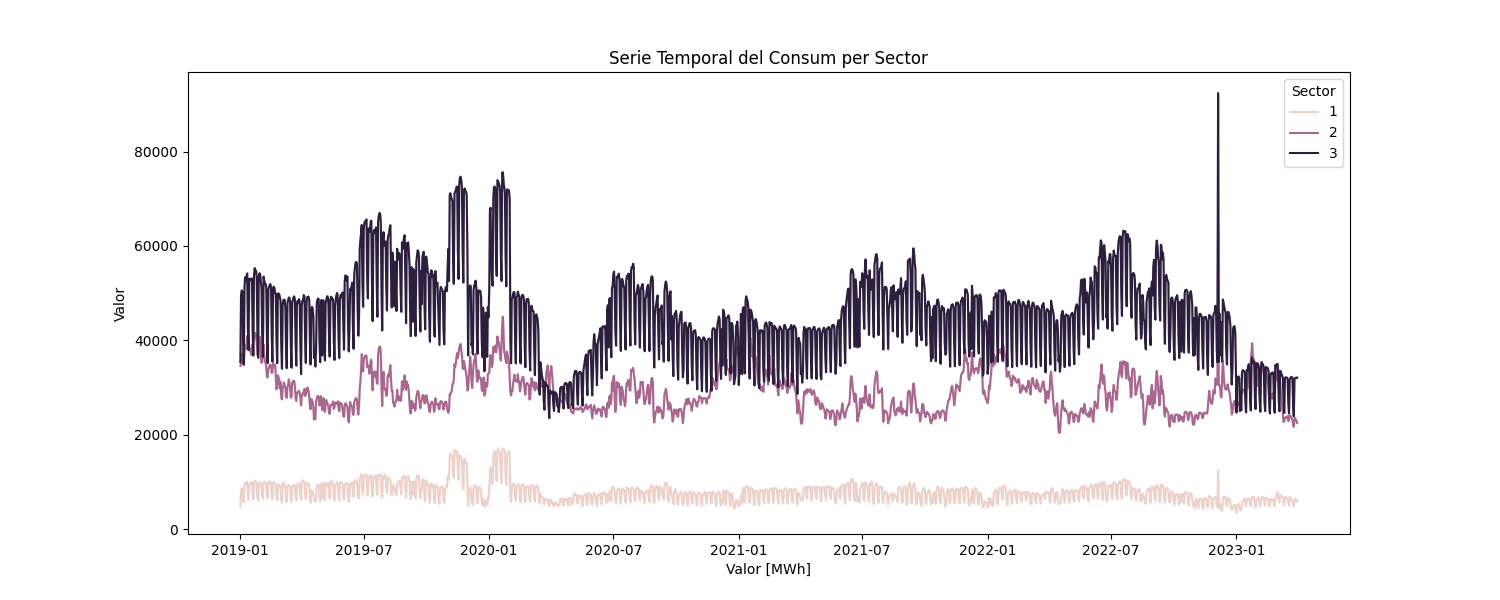

In [25]:
fig, ax = plt.subplots(figsize=(15,6))
sns.lineplot(x='Data', y='Valor',  hue='Sector', data=df[(df['Sector']!=0)], errorbar=('ci', 0.95))

ax.set_xlabel('Valor [MWh]')
ax.set_title('Serie Temporal del Consum per Sector')

plt.savefig('Valor_Temps_Sector.png')

A la sèrie Temporal del Consum per Tram, hi ha una bona correlació en els quatre trams en relació als pics i la tendència seguint, com ja comentat, el major consum en els cicles 3, 4, 2 i 1 respectivament.

<IPython.core.display.Javascript object>


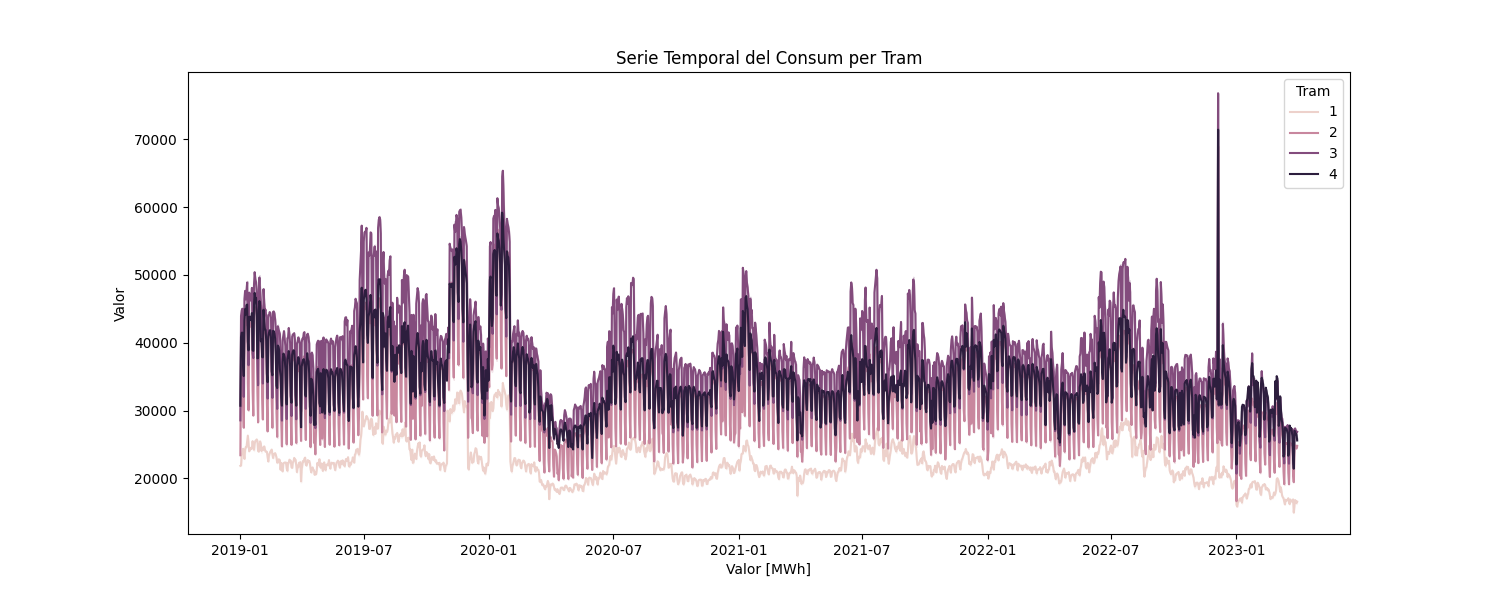

In [26]:
fig, ax = plt.subplots(figsize=(15,6))
sns.lineplot(x='Data', y='Valor',  hue='Tram', data=df[(df['Tram']!=0)], errorbar=('ci', 0.95))

ax.set_xlabel('Valor [MWh]')
ax.set_title('Serie Temporal del Consum per Tram')

plt.savefig('Valor_Temps_Tram.png')

Hem comentat sobre cicles i tendència però només a cop d'ull. A seguir extreurem la tendència i la estacionalitat per entendre millor les dades i saber si són importants. Farem servir la funció *seasonal_descompose* del paquet *statsmodel*.

Per tal d'extreure la tendència i estacionalitat hem de determinar la columna Data com a índex, i aquesta columna conté repeticions degut a que pel mateix dia, tenim dades dels diferents sectors, trams i Codi_Postal. Per no fer aquest exemple massa llarg, extreurem aquestes dades del Codi Postal 08028 pels sectors amb més consum, Residència i Serveis i el tram d'entre les 12h i les 18h. 

In [27]:
res_3 = df[(df['Sector']==2) & (df['Tram']==3) & (df['Codi_Postal'] == '08028')]
ser_3 = df[(df['Sector']==3) & (df['Tram']==3) & (df['Codi_Postal'] == '08028')]

series2 = res_3[['Data', 'Valor']]
series2 = series2.set_index('Data')
series2 = series2[series2['Valor']!=0]

series3 = ser_3[['Data', 'Valor']]
series3 = series3.set_index('Data')
series3 = series3[series3['Valor']!=0]


In [28]:
#Importem llibreries necessàries pels seguents passos

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

Primer farem gràfics de la autocorrelació, per intentar identificat periodes de estacionalitat

<IPython.core.display.Javascript object>


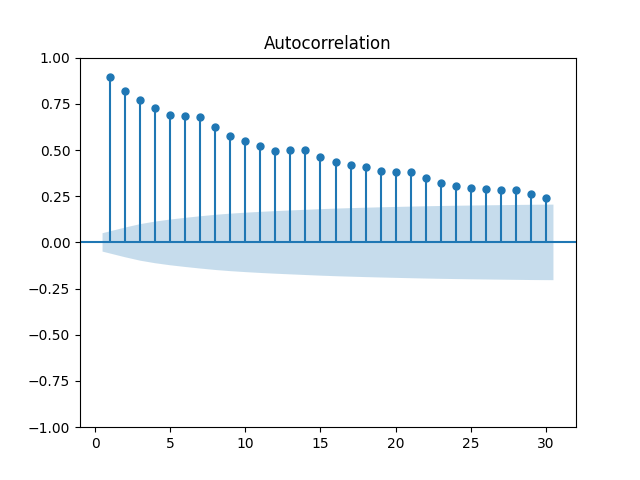

In [34]:
# Autocorrelació Residencial

fig, ax1 = plt.subplots()

fig = plot_acf(series2, lags=30, zero=False, ax=ax1)

plt.savefig('Autocorrelacio_Residencial.png')

<IPython.core.display.Javascript object>


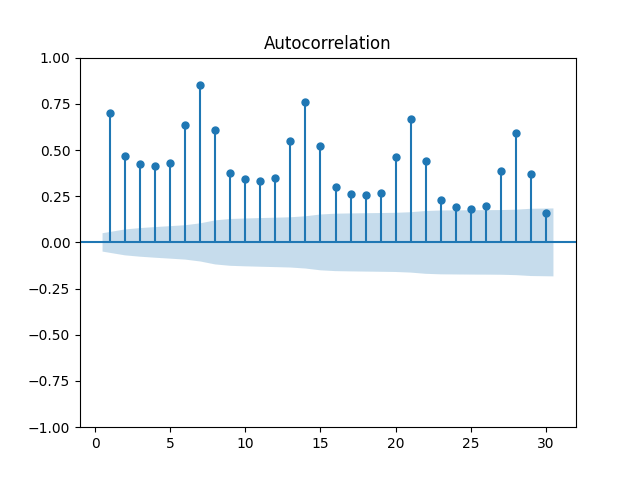

In [33]:
# Autocorrelació Serveis

fig, ax1 = plt.subplots()

fig = plot_acf(series3, lags=30, zero=False, ax=ax1)

plt.savefig('Autocorrelacio_Serveis.png')

En la autocorrelació per Residència, sembla que hi ha un cicle de 7 dies però molt poc evident comparat amb el de Serveis, on aquest cicle setmanal és molt clar. Continuarem l'anàlisis només amb aquest últim *dataframe*.

Descomposarem la sèrie temporal en tendència, estacionalitat i Residu.

<IPython.core.display.Javascript object>


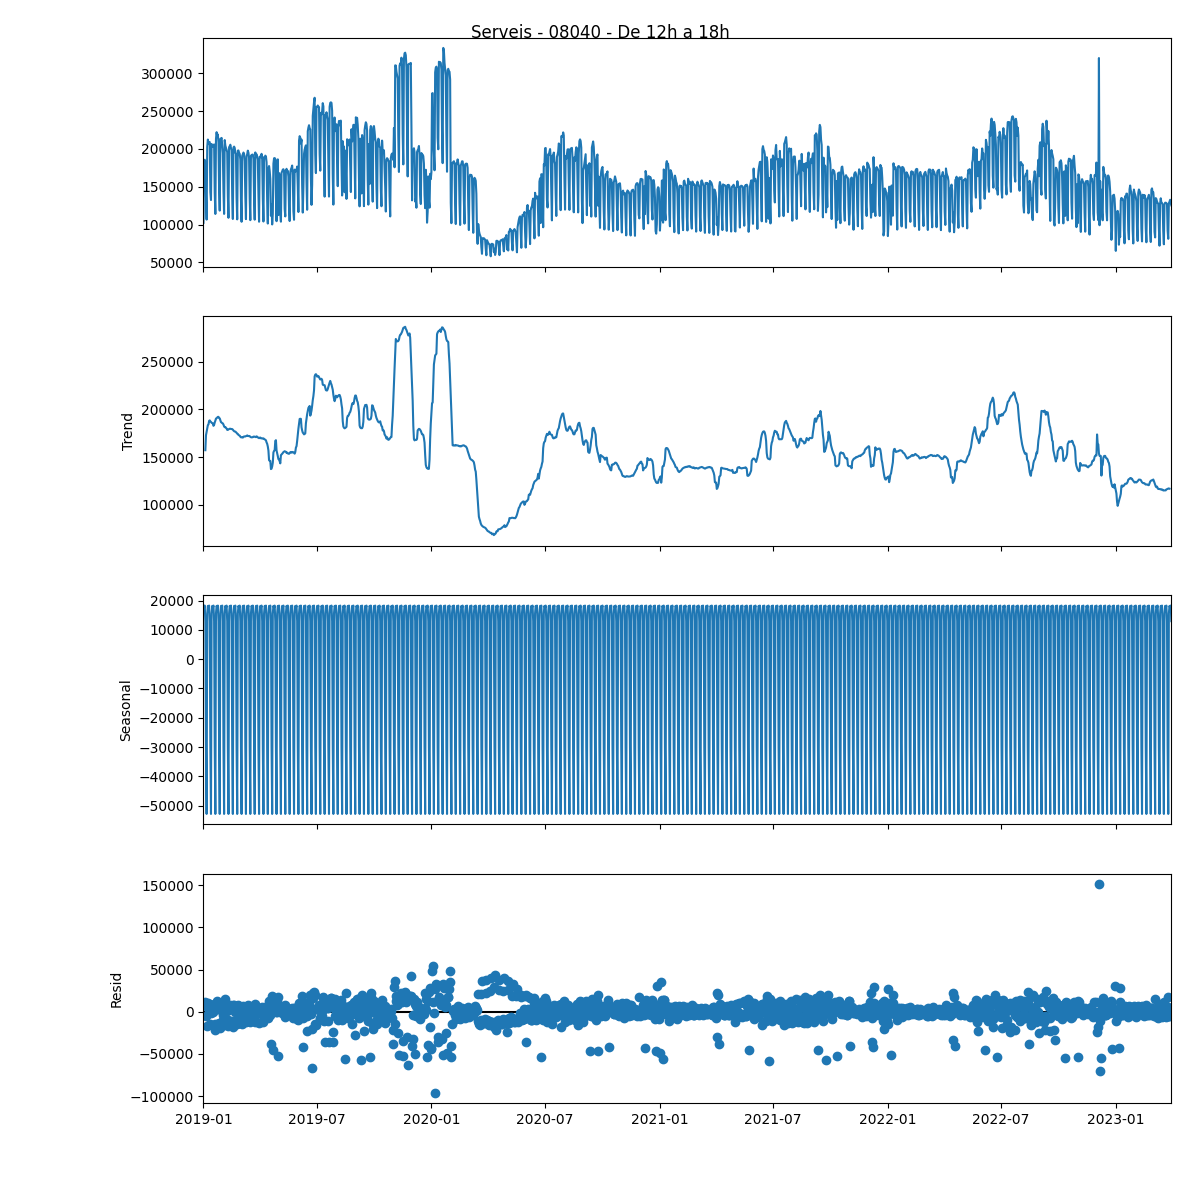

In [32]:
decompose_result_mult = seasonal_decompose(series3.asfreq('d'), model="additive", period=7)

trend = decompose_result_mult.trend
seasonal = decompose_result_mult.seasonal
residual = decompose_result_mult.resid

fig = decompose_result_mult.plot()
fig.set_size_inches(12,12)
fig.suptitle('Serveis - 08040 - De 12h a 18h')

plt.savefig('Descomposicio_Serveis_tram3.png')

No hi ha una tendència clara en aquests quatre anys de dades ja que hi ha moltes variacions al llarg dels mesos. Aquestes variacions s'haurien d'analitzar individualment en les dates i mirar de contextualitzar-les ja que, aparentment, no estàn lligades a cap cicle estacional de més llarga duració.

Ampliarem la estacionalitat, observant, per exemplr el març de 2019, per tal d'entendre millor aquests cicles setmanals:


<IPython.core.display.Javascript object>


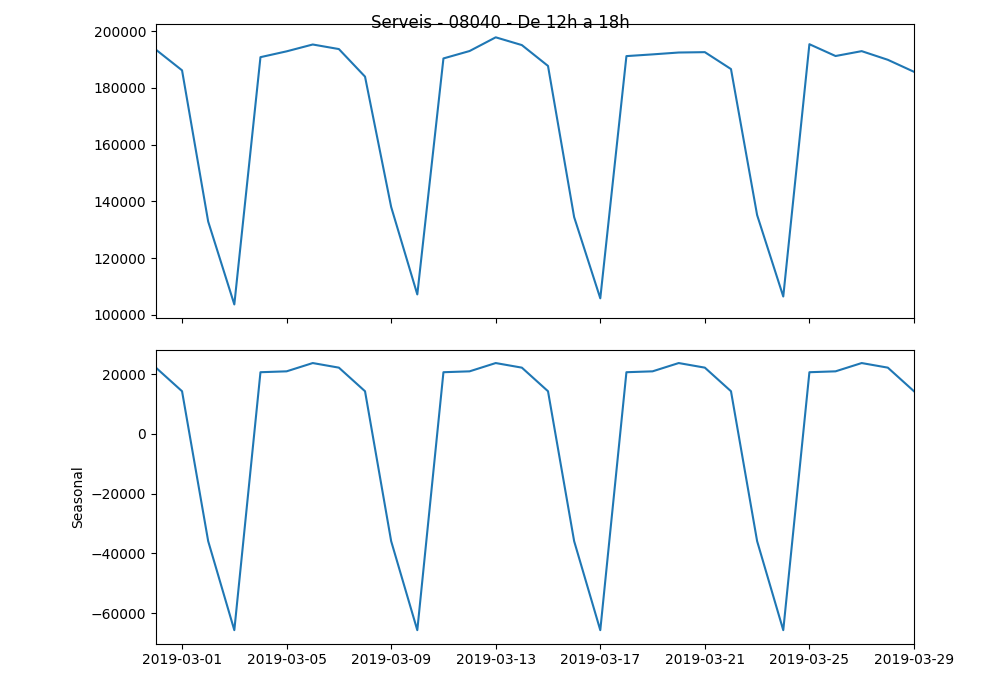

In [35]:
decompose_result_mult = seasonal_decompose(series3[58:88].asfreq('d'), model="additive")

trend = decompose_result_mult.trend
seasonal = decompose_result_mult.seasonal
residual = decompose_result_mult.resid

fig = decompose_result_mult.plot(observed=True, seasonal=True, trend=False,resid=False)
fig.suptitle('Serveis - 08040 - De 12h a 18h')
fig.set_size_inches(10,7)

plt.savefig('Descomposicio_estacional_marc2019.png')


Aqui observem el cicle setmanal clarament, on els punts més baixos són caps de setmana i els més alts entre setmana. Indicant una cicle setmanal de consum en aquest codi postal, sector serveis.

### ARIMA model

Per tal de mirar de fer prediccions amb aquestes dades, començarem utilitzant el model ARIMA. 
Com que treballarem amb aquest cicle de set dies, reduirem les dades i utilitzarem el 2022 per tal d'entrenar el model i el 2023 per fer algunes prediccions. En un model de sèries temporals, no podem dividir el *dataset* train i test de la manera usual, ja que no es poden fer servir dades futures per predir fets passats. D'aqui la divisió en aquesta línea de temps.


In [36]:
df_train = series3.loc['2022']
df_test = series3.loc['2023']

# Verifiquem que estàn ben ordenades
df_train.head()

Valor
Data              
2022-01-01   84819
2022-01-02  103701
2022-01-03  150119
2022-01-04  148431
2022-01-05  148346

<IPython.core.display.Javascript object>


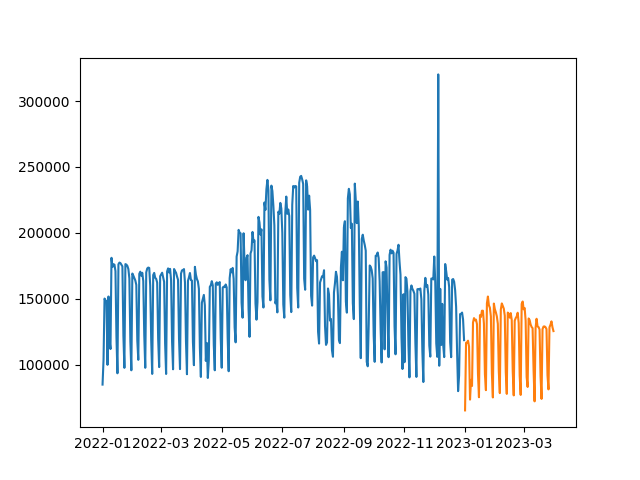

In [37]:
# Gràfic de les dades utilitzades
fig, ax = plt.subplots()

ax.plot(df_train)
ax.plot(df_test)

plt.savefig('train_test.png')

L'altre condició bàsica és que el nostre *dataframe* sigui estacionari. En cas contrari l'haurem de transformar.
Per saber si és o no estacionari, aplicarem el test adfuller.

Apliquem el test per saber si el df es estacionari. Si el p-value es menor que 0.05 rejectem la H0 i assumin que la nostra serie temporal es estacionaria. 


In [38]:
# Test pel df_train
from statsmodels.tsa.stattools import adfuller

result = adfuller(df_train.dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -2.210854
p-value: 0.202330


En aquest cas, no rejectem H0 i assumim que el *dataset* train no és estacionari.

Només com a curiositat, fem el mateix amb tota la sèrie temporal (series3) i veiem que en aquest cas sí que és estacionaria.

In [39]:
# Test per la serie completa series3

result = adfuller(series3.dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -3.895616
p-value: 0.002067


Transformem la sèrie en estacionaria i apliquem el test de nou:

In [40]:
df_train_diff = df_train.diff().dropna()
result = adfuller(df_train_diff.dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -6.224317
p-value: 0.000000


<IPython.core.display.Javascript object>


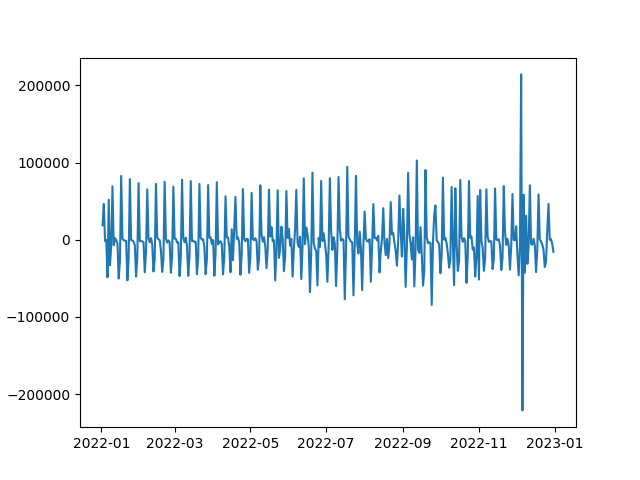

In [41]:
# Dades pel model ara estacionàries.
fig, ax = plt.subplots()

ax.plot(df_train_diff)

plt.savefig('train_transformat.png')

Abans de modelar la sèrie temporal, farem un gràfic de la autocorrelació i de la autocorrelació parcial per trobar la millor opció pels ordres del model ARIMA.

<IPython.core.display.Javascript object>


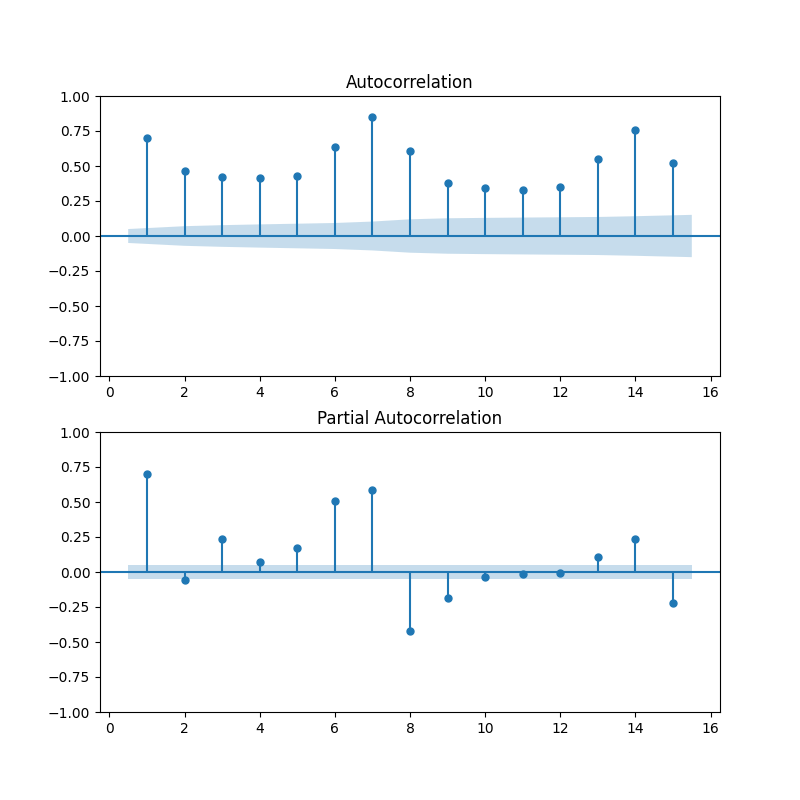

In [42]:
fig, (ax1,ax2) = plt.subplots(2,1, figsize=(8,8))

fig = plot_acf(series3, lags=15, zero=False, ax=ax1)
fig = plot_pacf(series3, lags=15, zero=False, ax=ax2)

plt.savefig('ACF_PACF.png')

Interpretant el gràfic anterior, podriem intentar un model AR(6), MA(7), però per estar-ne més segurs, una altra opció és generar models amb diferents combinacions d'ordres i comparar-los pel paràmetre AIC, que indica, com més baix el número, millor el model. També observerem el paràmetre BIC, que indica un model menys complex, també quant més baix el paràmetre millor el model. Si no ens importa la complexitat del model hem d'escollir pel AIC.

In [44]:
import warnings
warnings.filterwarnings('ignore')
from statsmodels.tsa.arima.model import ARIMA
# Create empty list to store search results
order_aic_bic=[]

# Loop over p values from 0-2
for p in range(11):
  # Loop over q values from 0-2
    for q in range(11):
      	# create and fit ARMA(p,q) model
        model = ARIMA(df_train_diff, order=(p,0,q), freq='D')
        results = model.fit()
        
        # Append order and results tuple
        order_aic_bic.append((p,q,results.aic, results.bic))

Transformem la llista en un *dataframe* i imprimim els valors en pantalla, de més petits a més grans. El parametre AIC indica el millor model independentment de la complexitat. 

In [45]:
# Construct DataFrame from order_aic_bic
order_df = pd.DataFrame(order_aic_bic, 
                        columns=['p', 'q', 'AIC', 'BIC'])

# Print order_df in order of increasing AIC
print(order_df.sort_values('AIC'))

# Print order_df in order of increasing BIC
print(order_df.sort_values('BIC'))

      p   q           AIC           BIC
109   9  10   8241.463965   8323.304196
74    6   8   8241.830974   8304.185436
97    8   9   8242.679208   8316.725132
119  10   9   8242.792824   8324.633055
73    6   7   8242.935220   8301.392528
..   ..  ..           ...           ...
44    4   0   8649.836035   8673.218958
33    3   0   8663.013631   8682.499401
22    2   0   8673.939490   8689.528106
11    1   0   8707.897173   8719.588634
0     0   0  10498.754198  10506.548506

[121 rows x 4 columns]
    p  q           AIC           BIC
73  6  7   8242.935220   8301.392528
74  6  8   8241.830974   8304.185436
84  7  7   8247.166915   8309.521377
75  6  9   8246.515556   8312.767172
85  7  8   8246.598472   8312.850088
.. .. ..           ...           ...
44  4  0   8649.836035   8673.218958
33  3  0   8663.013631   8682.499401
22  2  0   8673.939490   8689.528106
11  1  0   8707.897173   8719.588634
0   0  0  10498.754198  10506.548506

[121 rows x 4 columns]


Triarem el segon millor model AIC, ja que té resultats similars al primer però és menys complex pel número d'ordres.

In [46]:
model = ARIMA(df_train_diff, freq='D', order=(6,0,8))
model_fit = model.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Valor   No. Observations:                  364
Model:                 ARIMA(6, 0, 8)   Log Likelihood               -4104.915
Date:                Fri, 08 Sep 2023   AIC                           8241.831
Time:                        19:36:12   BIC                           8304.185
Sample:                    01-02-2022   HQIC                          8266.614
                         - 12-31-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         92.6729    432.983      0.214      0.831    -755.958     941.304
ar.L1         -0.9744      0.035    -27.594      0.000      -1.044      -0.905
ar.L2         -0.9922      0.016    -63.420      0.000      -1.023      -0.961
ar.L3         -0.9807      0.031    -31.618      0.000      -1.041      -0.920
ar.L4         -0.9810      0.026    -37.047      0.000      -1.033      -0.929
ar.L5         -0.9891      0.018    -53.678      0.000      -1.025      -0.953
ar.L6         -0.9681      0.037    -25.970      0.000      -1.041      -0.895
ma.L1          0.2984      0.059      5.070      0.000       0.183       0.414
ma.L2          0.3352      0.075      4.494      0.000       0.189       0.481
ma.L3          0.2779      0.081      3.416      0.001       0.118       0.437
ma.L4          0.2742      0.099      2.765      0.006       0.080       0.469
ma.L5          0.2574      0.093      2.764      0.006       0.075       0.440
ma.L6          0.2146      0.101      2.120      0.034       0.016       0.413
ma.L7         -0.5581      0.086     -6.465      0.000      -0.727      -0.389
ma.L8         -0.0255      0.084     -0.304      0.761      -0.190       0.139
sigma2       4.02e+08      0.003   1.53e+11      0.000    4.02e+08    4.02e+08
===================================================================================
Ljung-Box (L1) (Q):                   0.17   Jarque-Bera (JB):              5244.33
Prob(Q):                              0.68   Prob(JB):                         0.00
Heteroskedasticity (H):               4.17   Skew:                             0.13
Prob(H) (two-sided):                  0.00   Kurtosis:                        21.59
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.07e+26. Standard errors may be unstable.
"""

En el sumari anterior, podem veure la variable amb la qual treballem, el model utilitzat i paràmetres com *Log Likelihood*, *AIC* i *BIC* que ens ajuden a comparar el model amb altres. També veiem els paràmetres, referents a l'ordre utilitzat que seràn utilitzats per fer prediccions. Des de la constant, als sis paràmetres pel model AR i els 8 pel model MA. 

El gràfic dels residus ens ajuda a entendre si el model és o no bo. En principi, una distribució voltada al 0 com el gràfic de la dreta és un bon indicatiu.

<IPython.core.display.Javascript object>


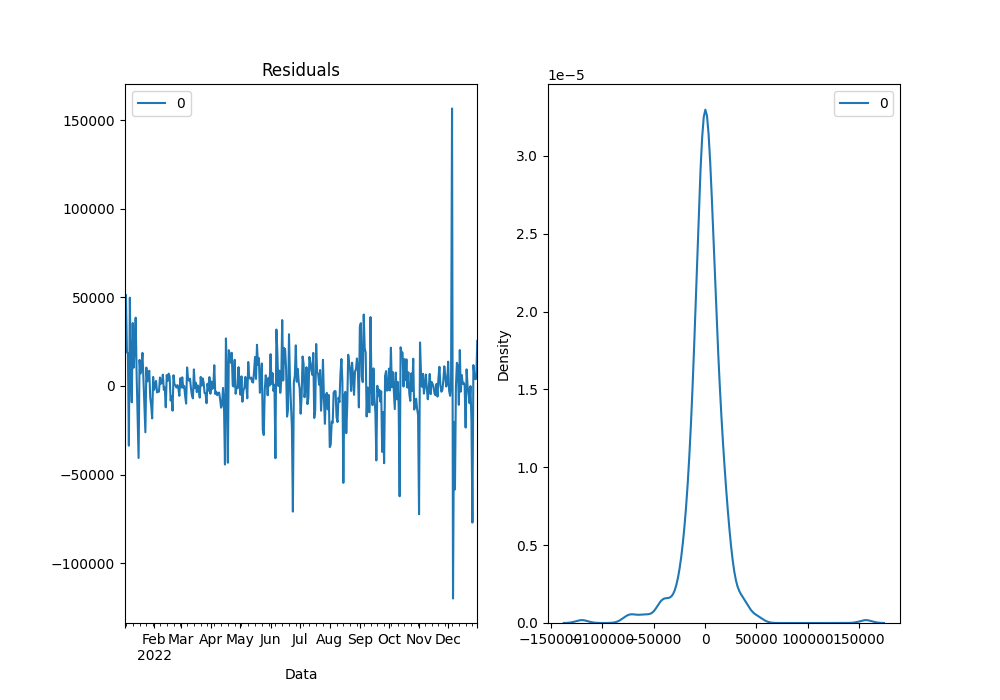

In [47]:
# Plot residual errors
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2, figsize=(10,7))
residuals.plot(title="Residuals", ax=ax[0])
sns.kdeplot(residuals,ax=ax[1])
plt.show()

plt.savefig('Residuals.png')

#### ARIMA prediccions

Farem les primeres prediccions amb dades incluides en el *dataset*. Intentarem reproduir les dades anant vint passos enrere, farem la predicció mitja i els interval de confiança. En farem el gràfic per visualitzar-ne els resultats.

<IPython.core.display.Javascript object>


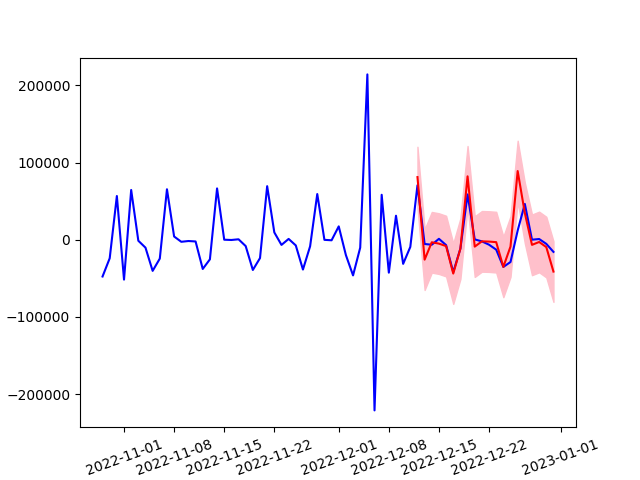

In [67]:
forecast = model_fit.get_prediction(start=-20, dynamic=False)
forecast_mean = forecast.predicted_mean
confident_intervals = forecast.conf_int()

plt.figure()
# GrÀfic predicció
plt.plot(df_train_diff.index[300:365], df_train_diff[300:365], color='blue', label='data')
plt.plot(forecast_mean.index, forecast_mean.values, color='red', label='forecast')
# Área d'incerteza uncertainty area
plt.fill_between(forecast_mean.index, confident_intervals['lower Valor'], confident_intervals['upper Valor'], color='pink')
plt.show()

plt.xticks(rotation=20)


plt.savefig('Prediccions_ARIMA.png')

El resultat és bo dintre de l'interval de confiança. Intentarem fer prediccions amb el mateix model, extraient la mitja i els intervals tal com abans, però ara amb dades 'futures'.

<IPython.core.display.Javascript object>


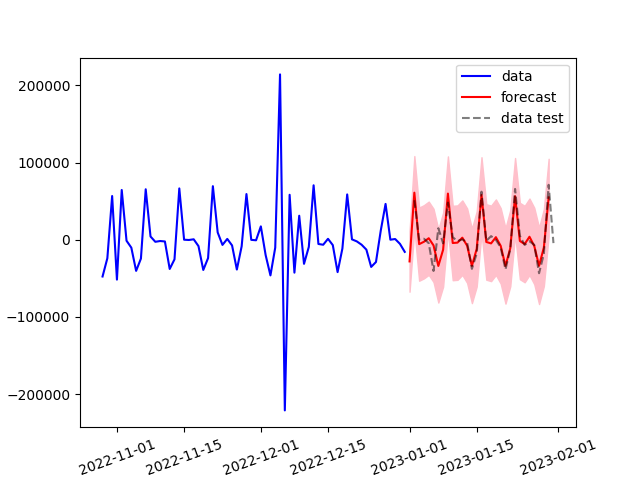

In [66]:
df_test_diff = df_test.diff().dropna()

forecast = model_fit.get_forecast(steps=30)

# predicció mitja
mean_forecast = forecast.predicted_mean

# Intervals de confiança
confidence_intervals = forecast.conf_int()

plt.figure()
# Gràfic predicció
plt.plot(df_train_diff.index[300:365], df_train_diff[300:365], color='blue', label='data')
plt.plot(mean_forecast.index, mean_forecast.values, color='red', label='forecast')
plt.plot(df_test_diff.index[0:30], df_test_diff[0:30], color='k', label='data test', alpha=0.5, ls='--')
# Área d'incerteza
plt.fill_between(mean_forecast.index, confidence_intervals['lower Valor'], confidence_intervals['upper Valor'], color='pink')
plt.legend()
plt.show()

plt.xticks(rotation=20)

plt.savefig('Prediccions2_ARIMA.png')

En blau, les dades transformades que hem fet servir per entrenar el model, en vermell les futures prediccions pels propers 30 dies amb l'interval de confiança, i en gris, tracejat, les dades de test (futures) per verificar el nostre model, el qual dóna uns resultats bastant bons.

De totes maneres, podem també fer un diagnòstic d'aquest model, per saber si es podria millorar encar més. Primer calculant l'error mínim absolut (mae) que seria utilitzat per comparar-lo amb el d'altres models, i després fent quatre gràfics de diagnòstic.

11451.474480569355


<IPython.core.display.Javascript object>


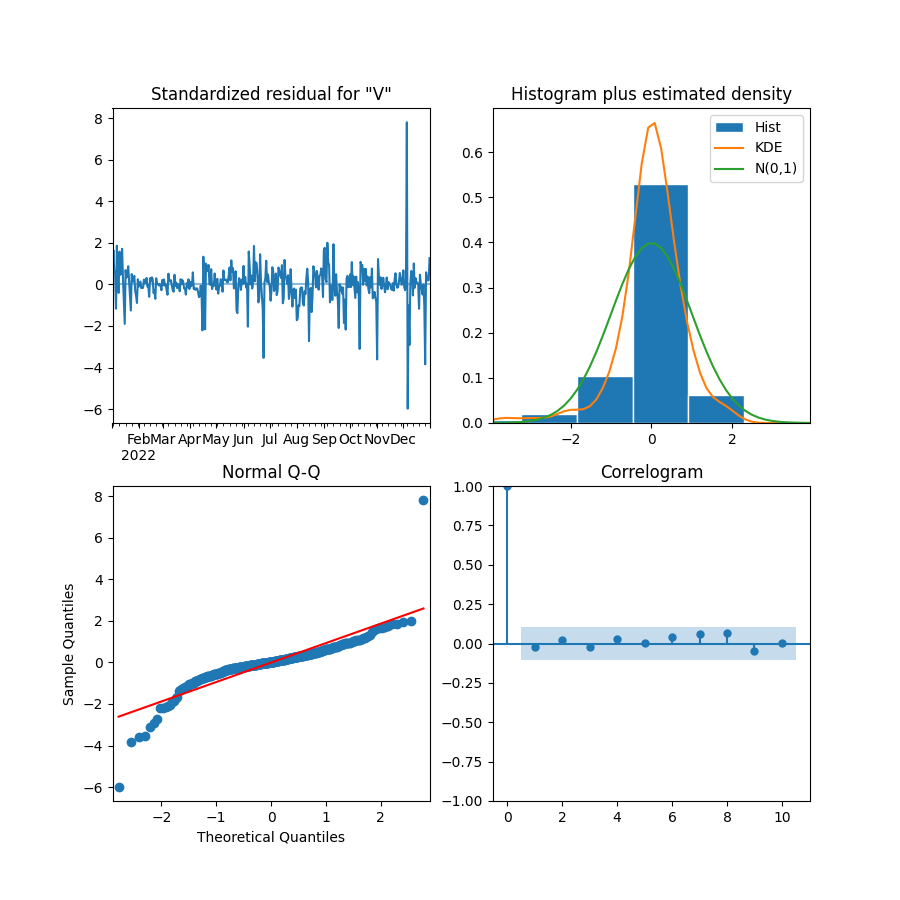

In [55]:
residuals = model_fit.resid

mae = np.mean(np.abs(residuals))
print (mae)

fig=model_fit.plot_diagnostics()
fig.set_size_inches(9,9)
plt.show()

plt.savefig('diagnostic_ARIMA.png')

De dalt a baix i de dreta a esquerra aquests gràfics ens indiquen:
1. No hi ha evidència d'estructura -> Bon model
2. Les curves verda i taronja haurien de ser més semblants -> model a millorar
3. La línea vermella i blava haurien de ser semblants -> model a millorar
4. Els lags (excepte el lag-0) no són significants en un interval de confiança del 95% -> Bon model

Tot i que els resultats són prou bons, el diagnòstic ens indica que es podria millorar. 

### SARIMAX

El model SARIMAX inclou tot el que hem vist del ARIMAX però considerant la estacionalitat. Anem a testar-lo per verificar si millora l'anterior.

En aquest cas, les variables d'ordre són tres per la part no estacional i quatre per la part estacional. Per triar l'ordre del model, seria més complex fer-ho de la manera anterior, provant diferents models i triant el menor AIC. La llibreria *pmdarima* ens ajuda en aquesta tasca.

In [56]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pmdarima as pm

In [57]:
model_SARIMAX = pm.auto_arima(df_train_diff,seasonal=True, m=7,d=0, D=0,  max_p=10, max_q=10, max_P=10, max_D=10,
                        information_criterion='aic', stepwise=True)

In [58]:
model_SARIMAX

ARIMA(order=(2, 0, 2), scoring_args={}, seasonal_order=(1, 0, 1, 7),
      suppress_warnings=True, with_intercept=False)

In [59]:
#model_SARIMAX_fit.summary()

Utilitzarem els ordres obtinguts, on la estacionalitat ha estat donada per nosaltres (m=7) després de comprobar l'estacionalitat setmanal.

In [60]:
model2 = SARIMAX(df_train_diff, freq='D', order=(2,0,2), seasonal_order=(1,0,1,7))
model_fit2 = model2.fit()
model_fit2.summary()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.15679D+01    |proj g|=  3.66485D-01

At iterate    5    f=  1.14156D+01    |proj g|=  2.44336D-02

At iterate   10    f=  1.13834D+01    |proj g|=  1.71562D-02

At iterate   15    f=  1.13759D+01    |proj g|=  3.79793D-03

At iterate   20    f=  1.13753D+01    |proj g|=  1.15937D-03


 This problem is unconstrained.



At iterate   25    f=  1.13753D+01    |proj g|=  1.86515D-03

At iterate   30    f=  1.13750D+01    |proj g|=  1.01149D-03

At iterate   35    f=  1.13750D+01    |proj g|=  1.95826D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     35     38      1     0     0   1.958D-05   1.138D+01
  F =   11.375007000183999     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                               Valor   No. Observations:                  364
Model:             SARIMAX(2, 0, 2)x(1, 0, [1], 7)   Log Likelihood               -4140.503
Date:                             Fri, 08 Sep 2023   AIC                           8295.005
Time:                                     19:52:07   BIC                           8322.285
Sample:                                 01-02-2022   HQIC                          8305.848
                                      - 12-31-2022                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8933      0.231     -3.873      0.000      -1.345      -0.441
ar.L2          0.0651      0.153      0.427      0.670      -0.234       0.364
ma.L1          0.2333      0.218      1.071      0.284      -0.194       0.660
ma.L2         -0.6617      0.172     -3.855      0.000      -0.998      -0.325
ar.S.L7        0.9973      0.006    179.031      0.000       0.986       1.008
ma.S.L7       -0.9168      0.077    -11.959      0.000      -1.067      -0.767
sigma2      7.196e+08   2.78e-10   2.59e+18      0.000     7.2e+08     7.2e+08
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              5440.56
Prob(Q):                              0.95   Prob(JB):                         0.00
Heteroskedasticity (H):               3.80   Skew:                             0.03
Prob(H) (two-sided):                  0.00   Kurtosis:                        21.94
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.26e+34. Standard errors may be unstable.
"""

Farem també les prediccions anant enrere en les dades *train* i seguidament les previsions futures pels propers 30 dies, verificant-les amb les dades *test*.

<IPython.core.display.Javascript object>


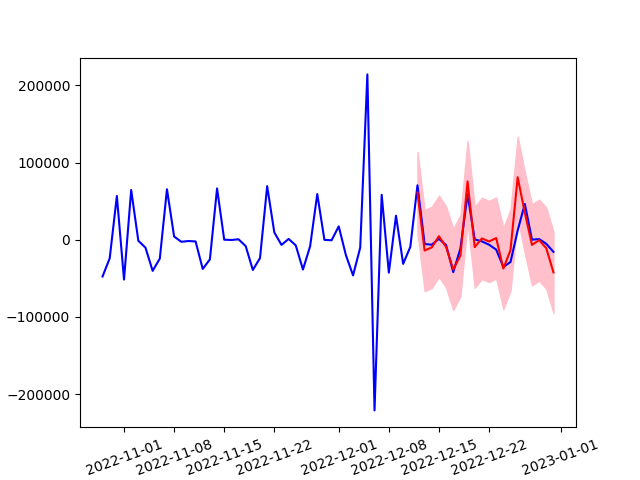

In [65]:
forecast2 = model_fit2.get_prediction(start=-20, dynamic=False)
forecast_mean2 = forecast2.predicted_mean
confident_intervals2 = forecast2.conf_int()

plt.figure()
# Gràfic predicció
plt.plot(df_train_diff.index[300:365], df_train_diff[300:365], color='blue', label='data')
plt.plot(forecast_mean2.index, forecast_mean2.values, color='red', label='forecast')
# Área d'incerteza uncertainty area
plt.fill_between(forecast_mean2.index, confident_intervals2['lower Valor'], confident_intervals2['upper Valor'], color='pink')
plt.show()

plt.xticks(rotation=20)

plt.savefig('Prediccions_SARIMAX.png')

<IPython.core.display.Javascript object>


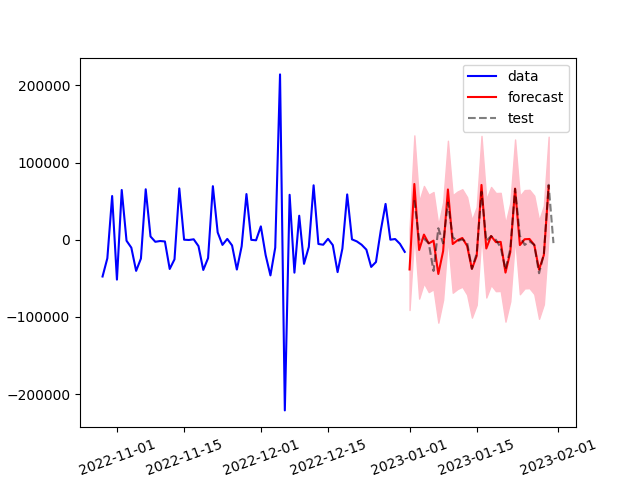

In [68]:
forecast2 = model_fit2.get_forecast(steps=30)

# forecast mean
mean_forecast2 = forecast2.predicted_mean

# Get confidence intervals of forecasts
confidence_intervals2 = forecast2.conf_int()

plt.figure()
# Plot prediction
plt.plot(df_train_diff.index[300:365], df_train_diff[300:365], color='blue', label='data')
plt.plot(mean_forecast2.index, mean_forecast2.values, color='red', label='forecast')
plt.plot(df_test_diff.index[0:30], df_test_diff[0:30], color='k', ls='--',label='test', alpha=0.5)
# Shade uncertainty area
plt.fill_between(mean_forecast2.index, confidence_intervals2['lower Valor'], confidence_intervals2['upper Valor'], color='pink')
plt.legend()
plt.show()

plt.xticks(rotation=20)

plt.savefig('Prediccion2s_SARIMAX.png')

Les prediccions amb aquest segon model semblen també bastant bones dins l'interval de confiança. Haurà millorat el diagnòstic comparat amb el model ARIMA?

11438.563623856395


<IPython.core.display.Javascript object>


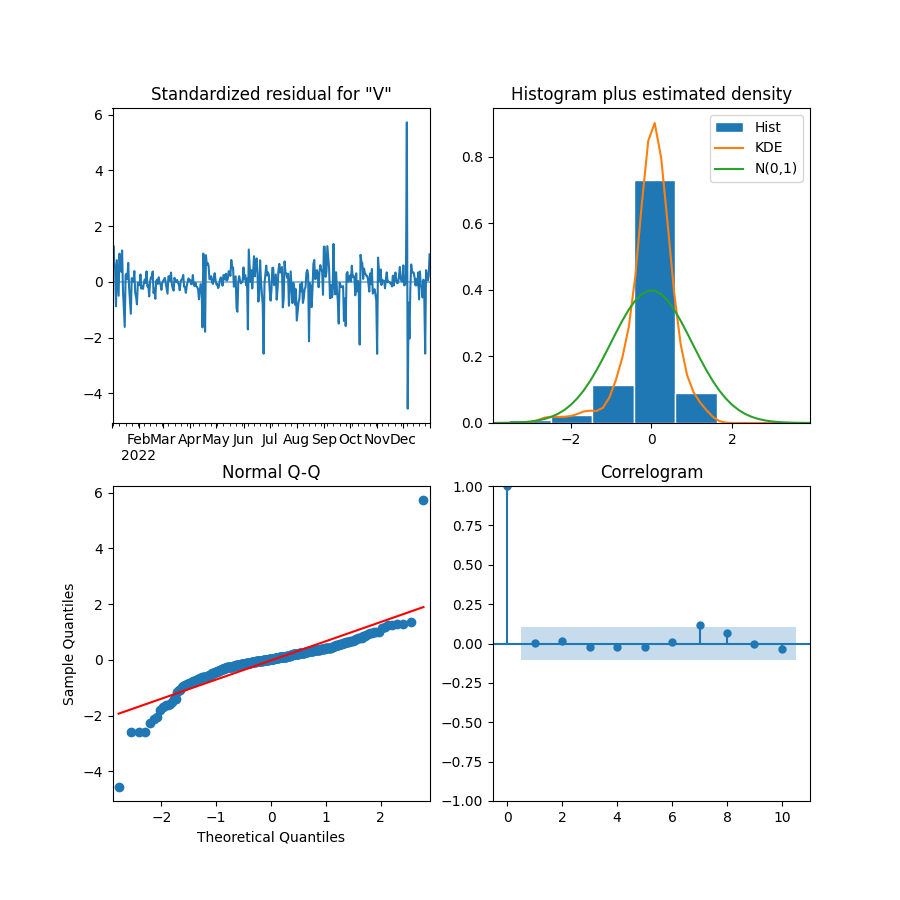

In [70]:
residuals2 = model_fit2.resid

mae2 = np.mean(np.abs(residuals2))
print (mae2)

fig=model_fit2.plot_diagnostics()
fig.set_size_inches(9,9)
plt.show()

plt.savefig('diagnostic_SARIMAX.png')

Obtenim un millor mae, però seguim amb alguns problemes de diagnòstic amb l'histograma i els quantils.

Farem una predicció de 60 dies futurs, per veure si el model continua robust amb la comparació de dades futures (dades test)

<IPython.core.display.Javascript object>


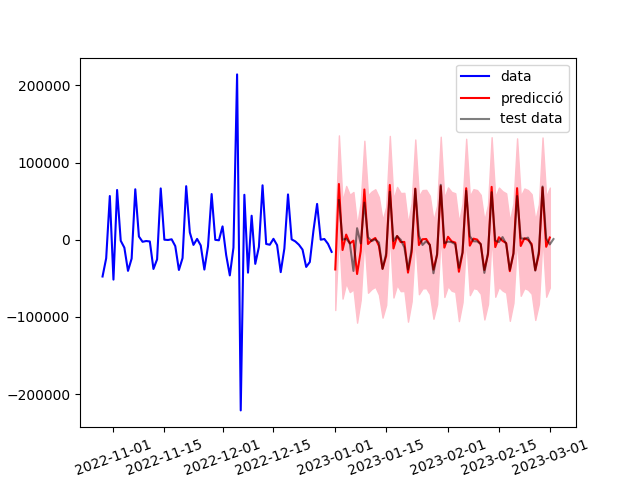

In [81]:
forecast2 = model_fit2.get_forecast(steps=60)

# Predicció mitja
mean_forecast2 = forecast2.predicted_mean

# Intervals de confiança
confidence_intervals2 = forecast2.conf_int()

plt.figure()
# Predicció
plt.plot(df_train_diff.index[300:365], df_train_diff[300:365], color='blue', label='data')
plt.plot(mean_forecast2.index, mean_forecast2.values, color='red', label='predicció')
plt.plot(df_test_diff.index[0:60], df_test_diff[0:60], color='k', label='test data', alpha=0.5)
# Área incerteza
plt.fill_between(mean_forecast2.index, confidence_intervals2['lower Valor'], confidence_intervals2['upper Valor'], color='pink')
plt.legend()
plt.show()

plt.xticks(rotation=20)

plt.savefig('Prediccio_SARIMAX_60.png')

Aparentment amb aquest model estem aconseguint bones prediccions.

Si el model és complex, triar l'ordere d'un model SARIMAX pot consumir bastanta temps de CPU. Si estem contents amb el nostre model el podem guardar per reutilitzar-lo i actualitzar-lo si tenim noves dades. 

In [72]:
import joblib

In [78]:
path='model_SARIMAX.pkl'

In [79]:
joblib.dump(model_fit2, path)

['model_SARIMAX.pkl']

Un cop salvat el podem carregar d'aquesta manera:

In [80]:
# load the model

model_SARIMAX = joblib.load('model_SARIMAX.pkl')

Això ens ajudarà a reutilitzar el model, i actualitzar-lo amb noves dades si necessàri.